In [27]:
from utilities import *

In [28]:
############### User Configuration ###############
##################################################

datadir = "." # All ZDA files in this directory + subdirectories are loaded
selected_filename = "05_01_05" # focus for subsequent analysis

# Spatial area to investigate
y_range = [45,-2] #[10, 40]
x_range = [0,-2] #[41, 79]

# Temporal area to investigate
time_window = [40,-1]

In [29]:
############## Driver script: begin ##############
##################################################

# Load data
processed = [] # to avoid re-processing later
all_data = load_all_zda(data_dir=datadir + "/zda_targets")

# Selected data of interest
for file in all_data:
    if selected_filename in file[0]:
        selected_filename = file[0]
        
raw_data = all_data[file[0], 'data']
meta = all_data[file[0], 'meta']
rli = all_data[file[0], 'rli']
        

./zda_targets/05_01_05.zda
Number of files loaded: 1


(5, 80, 80, 600)


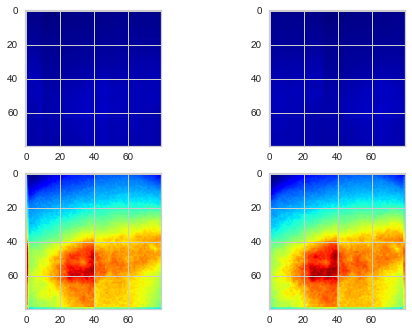

In [30]:
# view frames
fig, axes = plt.subplots(2, 2)
print(raw_data.shape)
axes[1][0].imshow(raw_data[0,:,:,0],cmap='jet')
axes[1][1].imshow(raw_data[0,:,:,-1],cmap='jet')
axes[0][0].imshow(raw_data[1,:,:,0],cmap='jet')
axes[0][1].imshow(raw_data[4,:,:,-1],cmap='jet')
plt.show()

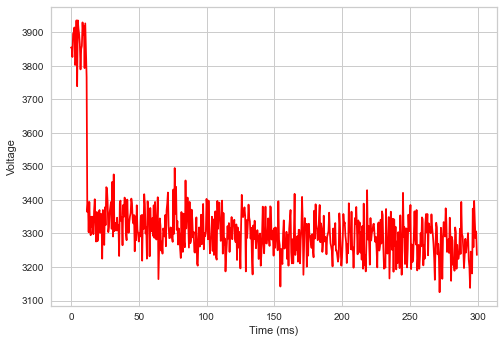

In [31]:
# view a trace
plot_trace(raw_data, 40, 40, meta['interval_between_samples'], trial=0)

In [32]:
# Cut to time window of interest (could be just after simulation)
raw_data = raw_data[:,:,:,time_window[0]:time_window[1]]

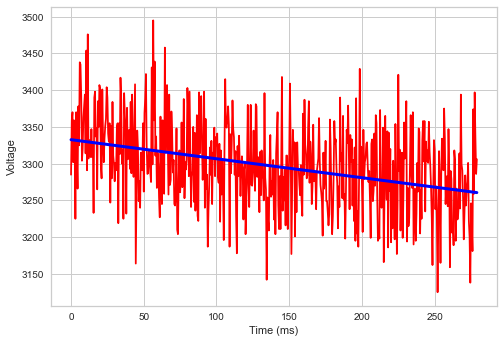

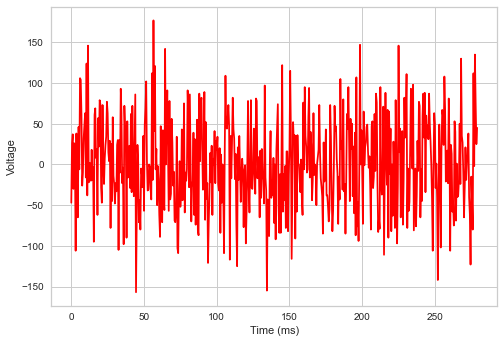

In [33]:
# Run this cell at most once per ZDA load
# Need to subtract off the low-frequency voltage drift. First-order correction
correct_background(meta, raw_data)

#full trace
plot_trace(raw_data[:,:,:,:], 
           40, 
           40, 
           meta['interval_between_samples'], 
           trial=0)


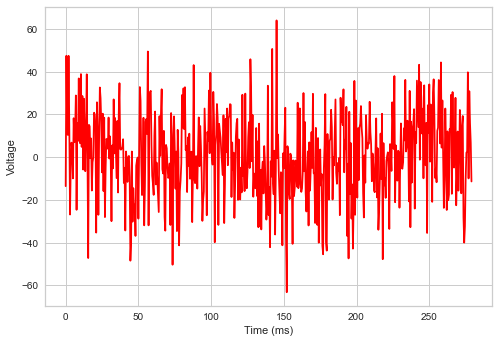

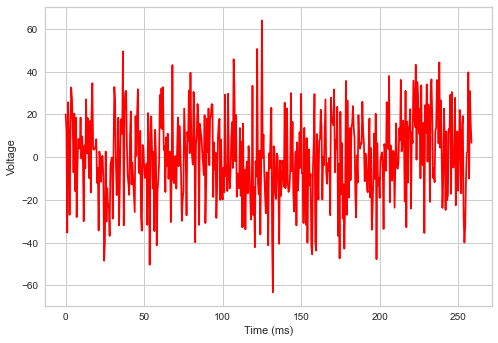

In [34]:
# spatial and temporal filtering to handle random noise
filtered_data = filter_temporal(meta, raw_data)
filtered_data = filter_spatial(meta, raw_data)

#full trace
plot_trace(filtered_data[:,:,:,:],
           40, 
           40,
           meta['interval_between_samples'], 
           trial=0)

# time window of interest (stim)
plot_trace(filtered_data[:,:,:,time_window[0]:time_window[1]], 
          40, 
          40, 
          meta['interval_between_samples'],
          trial=0)

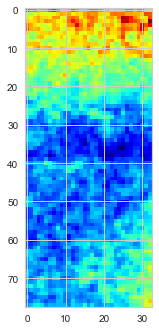

max SNR: 0.03206919557113206 min SNR: 0.0193795722174676


In [35]:
# Examine SNR

# Spatial area to investigate
y_range = [45,-2] #[10, 40]
x_range = [0,-2] #[41, 79]

trial = filtered_data[0, x_range[0]:x_range[1], 
                    y_range[0]:y_range[1], :] 
trials = filtered_data[:, x_range[0]:x_range[1], 
                     y_range[0]:y_range[1], :] 

snr = np.mean(trial, axis=2) / np.std(trial, axis=2)

plt.imshow(snr, cmap='jet', interpolation='nearest')
plt.show()

print("max SNR:", np.max(snr), "min SNR:", np.min(snr))

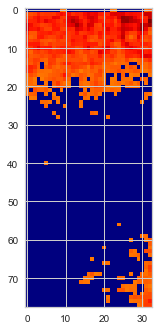

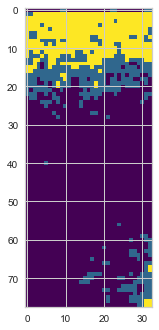

In [36]:
# impose snr cutoff
snr_percentile_cutoff = 0.7
k_clusters = 3
snr_cutoff = np.percentile(snr,
                           snr_percentile_cutoff * 100)

mask = (snr >= snr_cutoff).astype(np.float)

# masked image: reasonability check
plt.imshow(snr * mask, cmap='jet', interpolation='nearest')
plt.show()

# 1-D K-means clustering of SNR groups
km = KMeans(n_clusters=k_clusters+1).fit(snr.reshape(-1,1)) # +1 for the masked 0's

clustered = np.array(km.labels_).reshape(snr.shape) + 1
clustered = clustered.astype(np.float)

plt.imshow(clustered * mask, cmap='viridis', interpolation='nearest')
plt.show()

In [37]:
# SNR by cluster
avg_snr_by_cluster = [np.average(snr[np.where(clustered==i)[0]]) for  i in range(1, k_clusters+2)]
print(avg_snr_by_cluster)

cluster_indices_by_snr = np.argsort(np.array(avg_snr_by_cluster)) + 1
highest_snr_cluster = cluster_indices_by_snr[-1]
print(cluster_indices_by_snr)
print("highest_snr_cluster =", highest_snr_cluster)

[0.02511359520402295, 0.022437174976758498, 0.02777235576101745, 0.023276853223910193]
[2 4 1 3]
highest_snr_cluster = 3


Pixel at (1 , 2)


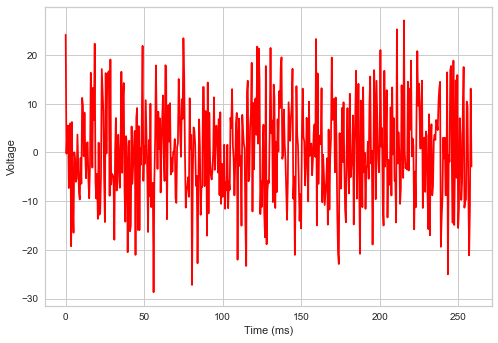

Pixel at (3 , 14)


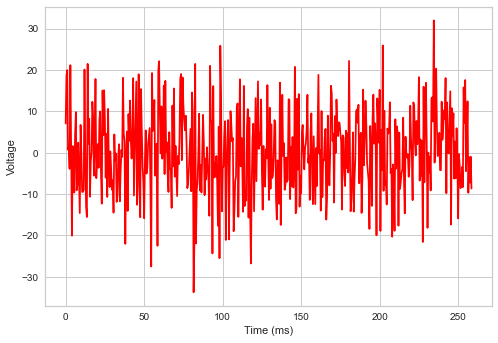

Pixel at (5 , 30)


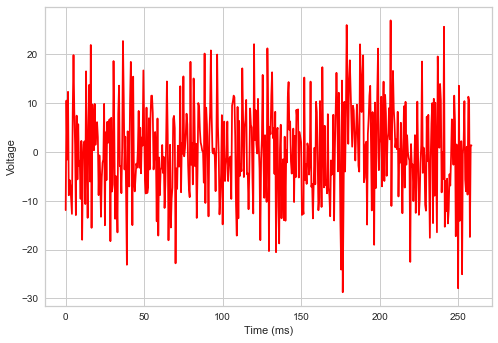

Pixel at (8 , 29)


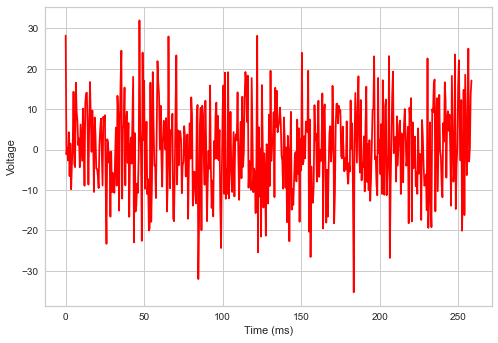

Pixel at (11 , 21)


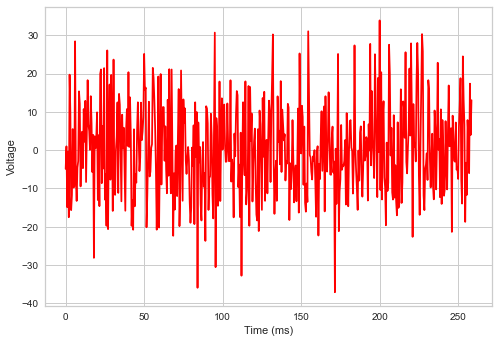

Pixel at (77 , 32)


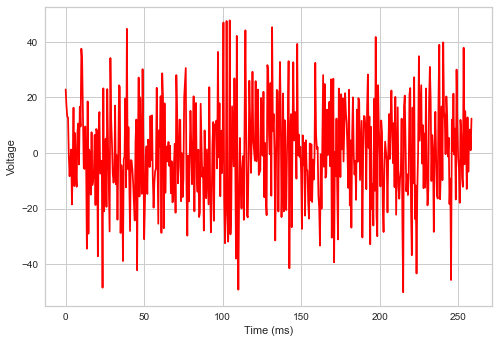

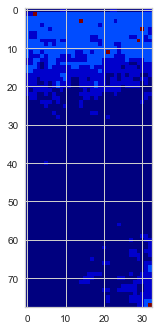

In [38]:
# Examine some higher-SNR pixels
n_samples = 5
mask = (snr >= snr_cutoff).astype(np.float)

# Select the pixels in the highest SNR cluster, above SNR cutoff
argmaxes =  np.where(clustered * mask == highest_snr_cluster)
max_samples = argmaxes[0].shape[0]
for i in range(0, max_samples, int(max_samples / n_samples) ):

    x_max = argmaxes[0][i]
    y_max = argmaxes[1][i]
    print("Pixel at (" + str(x_max), ",", str(y_max) + ")")
    plot_trace(trials[:,:,:,time_window[0]:time_window[1]], 
               x_max, 
               y_max, 
               meta['interval_between_samples'], 
               trial=0)

    mask[x_max, y_max] *= 5 # highlight

plt.imshow(clustered * mask, cmap='jet', interpolation='nearest')
plt.show()


Pixel at (0 , 9)
	 max amplitude: 28.74354362487793 at: 491 
	 half width: 5.516707106549518
Pixel at (0 , 10)
	 max amplitude: 26.609039306640625 at: 174 
	 half width: 5.036162276431867
Pixel at (0 , 22)
	 max amplitude: 25.254289627075195 at: 455 
	 half width: 4.415131336142508
Pixel at (0 , 23)
	 max amplitude: 28.78372573852539 at: 39 
	 half width: 6.136120421981289
Pixel at (0 , 31)
	 max amplitude: 31.82691192626953 at: 38 
	 half width: 4.179657727753828
Pixel at (0 , 32)
	 max amplitude: 24.950908660888672 at: 475 
	 half width: 4.113095059129023
Pixel at (1 , 0)
	 max amplitude: 35.85922622680664 at: 261 
	 half width: 4.491059564372506
Pixel at (1 , 1)
	 max amplitude: 35.7524299621582 at: 54 
	 half width: 3.5727673295974043
Pixel at (1 , 3)
	 max amplitude: 30.58808708190918 at: 71 
	 half width: 3.4819888344170096
Pixel at (1 , 4)
	 max amplitude: 31.228302001953125 at: 214 
	 half width: 4.588195448444623
Pixel at (1 , 5)
	 max amplitude: 29.272546768188477 at: 130 
	 

Pixel at (10 , 21)
	 max amplitude: 0.0 at: 12 
	 half width: 0.0
Pixel at (10 , 22)
	 max amplitude: 0.0 at: 400 
	 half width: 0.0
Pixel at (10 , 23)
	 max amplitude: 0.0 at: 458 
	 half width: 0.0
Pixel at (10 , 24)
	 max amplitude: 0.0 at: 458 
	 half width: 0.0
Pixel at (10 , 25)
	 max amplitude: 0.0 at: 436 
	 half width: 0.0
Pixel at (10 , 26)
	 max amplitude: 0.0 at: 391 
	 half width: 0.0
Pixel at (10 , 27)
	 max amplitude: 0.0 at: 391 
	 half width: 0.0
Pixel at (10 , 28)
	 max amplitude: 0.0 at: 398 
	 half width: 0.0
Pixel at (10 , 29)
	 max amplitude: 0.0 at: 412 
	 half width: 0.0
Pixel at (10 , 30)
	 max amplitude: 0.0 at: 425 
	 half width: 0.0
Pixel at (10 , 31)
	 max amplitude: 0.0 at: 177 
	 half width: 0.0
Pixel at (10 , 32)
	 max amplitude: 0.0 at: 29 
	 half width: 0.0
Pixel at (11 , 0)
	 max amplitude: 0.0 at: 196 
	 half width: 0.0
Pixel at (11 , 1)
	 max amplitude: 0.0 at: 288 
	 half width: 0.0
Pixel at (11 , 2)
	 max amplitude: 0.0 at: 288 
	 half width: 0.0


	 max amplitude: 0.0 at: 58 
	 half width: 0.0
Pixel at (20 , 16)
	 max amplitude: 0.0 at: 152 
	 half width: 0.0
Pixel at (20 , 17)
	 max amplitude: 0.0 at: 181 
	 half width: 0.0
Pixel at (20 , 18)
	 max amplitude: 0.0 at: 511 
	 half width: 0.0
Pixel at (20 , 19)
	 max amplitude: 0.0 at: 511 
	 half width: 0.0
Pixel at (20 , 20)
	 max amplitude: 0.0 at: 274 
	 half width: 0.0
Pixel at (20 , 21)
	 max amplitude: 0.0 at: 197 
	 half width: 0.0
Pixel at (20 , 22)
	 max amplitude: 0.0 at: 197 
	 half width: 0.0
Pixel at (20 , 23)
	 max amplitude: 0.0 at: 404 
	 half width: 0.0
Pixel at (20 , 24)
	 max amplitude: 0.0 at: 275 
	 half width: 0.0
Pixel at (20 , 26)
	 max amplitude: 0.0 at: 479 
	 half width: 0.0
Pixel at (20 , 27)
	 max amplitude: 0.0 at: 83 
	 half width: 0.0
Pixel at (20 , 28)
	 max amplitude: 0.0 at: 83 
	 half width: 0.0
Pixel at (20 , 29)
	 max amplitude: 0.0 at: 293 
	 half width: 0.0
Pixel at (21 , 0)
	 max amplitude: 0.0 at: 34 
	 half width: 0.0
Pixel at (21 , 2)
	

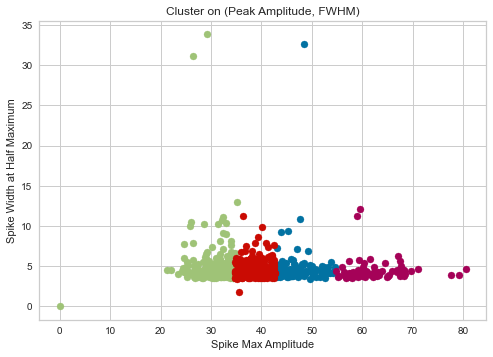

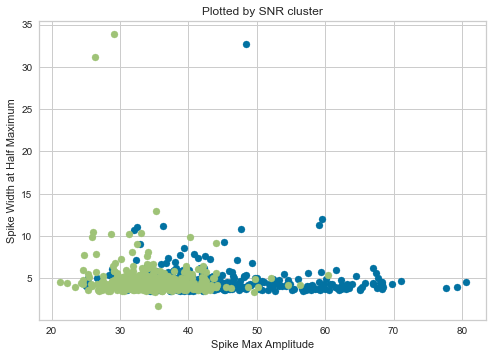

In [39]:
# Spike sorting on the template-matched images

# We are looking for two patterns of shapes:
#   1) sub-threshold ESPSs 
#         - lower amplitude
#         - wider half-width
#   2) spikes
#         - higher amplitude
#         - narrow half-width

k_2d_clusters = 4 # choose via silhouette coefficient

trial = filtered_data[0, x_range[0]:x_range[1], 
                    y_range[0]:y_range[1], :] 
trials = filtered_data[:, x_range[0]:x_range[1], 
                     y_range[0]:y_range[1], :] 

# Let's do 1-D clustering by max amplitude
#   looking, for now, only in the time frame near stim and highest-SNR cluster

# Select the pixels in the highest SNR cluster, above SNR cutoff
px_selector = np.zeros(clustered.shape)
clusters_selected = cluster_indices_by_snr[-2:]
for c in clusters_selected:
    px_selector += (clustered * mask == c)

argmaxes =  np.where(px_selector > 0)
features = np.zeros((argmaxes[0].shape[0], 3))  # (max amp, half-width, cluster index)
i_filled = 0
for i in range(argmaxes[0].shape[0]):

    x_max = argmaxes[0][i]
    y_max = argmaxes[1][i]

    window = trial[x_max,
                   y_max,
                   time_window[0]:time_window[1]]


    # Calculate width at half-max, assuming min is zero 
    #   (valid assumption due to our fitted lin/exp correction)
    hm = features[i,0] / 2.0
    arg_max = np.argmax(window)

    fwhm = get_half_width(arg_max, window)

    # invalid spike, do not store
    if fwhm is None:
        continue
    
    features[i_filled,0] = np.max(window)
    features[i_filled,1] = fwhm
    features[i_filled,2] = clustered[x_max, y_max]
    i_filled += 1

    print("Pixel at (" + str(x_max), 
          ",", 
          str(y_max) + ")\n\t max amplitude:", 
          features[i,0], 
          "at:",
          arg_max,
          "\n\t half width:", 
          features[i,1])
    #plot_trace(trial[:,:,time_window[0]:time_window[1]],
    #           x_max,
    #           y_max,
    #           meta['interval_between_samples'] )

features = features[:i_filled+1, :]

# 2-D K-means clustering on features (max amp, half width)
label = KMeans(n_clusters=k_2d_clusters).fit_predict(features)

for i in range(k_2d_clusters):
    filtered_label = features[label == i]

    plt.scatter(filtered_label[:,0] , filtered_label[:,1])

plt.title("Cluster on (Peak Amplitude, FWHM)")
plt.ylabel("Spike Width at Half Maximum")
plt.xlabel("Spike Max Amplitude")
plt.show()

# plot by SNR cluster
for c in clusters_selected:
    filtered_label = features[features[:, 2] == c]

    plt.scatter(filtered_label[:,0] , filtered_label[:,1])

plt.title("Plotted by SNR cluster")
plt.ylabel("Spike Width at Half Maximum")
plt.xlabel("Spike Max Amplitude")
plt.show()


Silhouette score: 0.4491934492327077


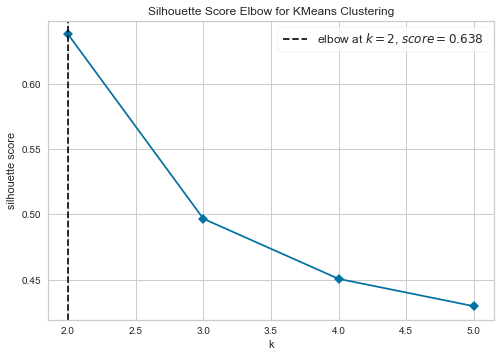

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [40]:
# Silhouette analysis

print("Silhouette score:", silhouette_score(features, label))

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,6), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(features)    
visualizer.poof()   